# Beleg 1- Ela Kilic 593982

## Datensatz

In [1]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from numpy import arange, array, ones, linalg
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import load_diabetes

In [2]:
iris = datasets.load_iris()
np.random.seed(42)

diabetes = load_diabetes()

In [3]:
print(f"Anzahl Datenpunkte: {len(iris.data)}")
print(f"Anzahl verschiedener Lilienarten: {len(np.unique(iris.target))}")
print(f"Eigenschaften: {iris.feature_names}")

Anzahl Datenpunkte: 150
Anzahl verschiedener Lilienarten: 3
Eigenschaften: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


### Plot

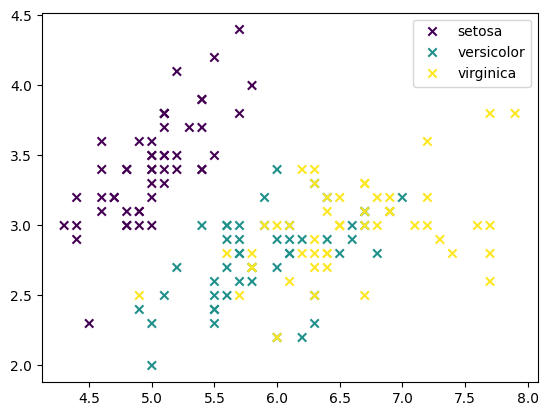

In [4]:
def plot_first_two(x,y):
    scatter = plt.scatter(x, y, c=iris.target, marker='x')
    plt.legend(scatter.legend_elements()[0], iris.target_names)
    plt.show()

x_input = iris.data[:, :2]
x_first = x_input[:, 0]
y_first = x_input[:, 1]

plot_first_two(x_first,y_first)

## Logistisches Modell

### Funktionen

In [5]:
def logistic_model(theta):
    def model(x):
        y = []
        for xi in x:
            z = theta[0] + np.dot(theta[1:], xi)
            yi = 1 / (1 + np.exp(-z))
            y.append(yi)
        return np.array(y)
    return model
    #return lambda x: 1 / (1 + np.exp(-theta[0] - np.dot(theta[1:], x)))


def grad_logistic_model(x, theta):
    G = np.zeros([len(x), len(theta)])
    for i in range(len(x)):
        xi = x[i]
        z = theta[0] + np.dot(theta[1:], xi)
        G[i][0] = np.exp(-z) / ((1 + np.exp(-z)) ** 2)
        G[i][1:] = (np.exp(-z) / ((1 + np.exp(-z)) ** 2)) * xi
    return G

### Plot

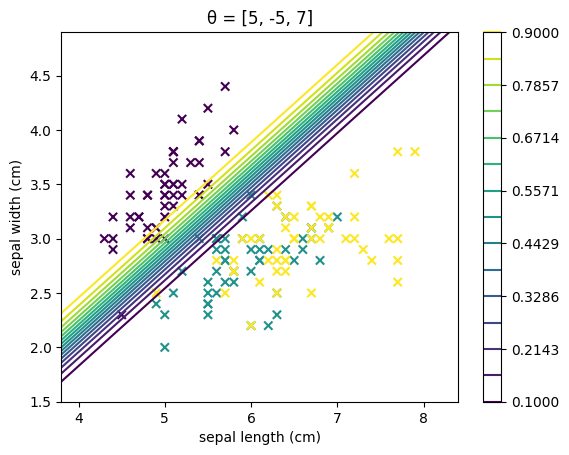

In [6]:
def plot_with_model(X, theta):
    x = X[:, 0]
    y = X[:, 1]

    x_grid = np.linspace(x.min() - 0.5, x.max() + 0.5, 100)
    y_grid = np.linspace(y.min() - 0.5, y.max() + 0.5, 100)
    Xg, Yg = np.meshgrid(x_grid, y_grid)

    grid_pts = np.c_[Xg.ravel(), Yg.ravel()]
    model = logistic_model(theta)(grid_pts)
    Z = model.reshape(Xg.shape)

    fig, ax = plt.subplots()
    contour = ax.contour(Xg, Yg, Z, levels=np.linspace(0.1, 0.9, 15))
    scatter = ax.scatter(x, y, c=iris.target, marker='x')

    ax.set_xlabel(iris.feature_names[0])
    ax.set_ylabel(iris.feature_names[1])
    ax.set_title(f'θ = [{theta[0]}, {theta[1]}, {theta[2]}]')
    plt.colorbar(contour)
    plt.show()

theta = np.array([5, -5, 7])
plot_with_model(x_input, theta)

## Kostenfunktionen

In [7]:
def mse_cost_function(x, y, model_fct):
    """
    def func(theta):
        predictions = model_fct(theta)(x)
        errors = predictions - y  # h_theta(x)-y
        cost = (1 / (2 * len(x))) * np.sum(errors ** 2)
        return cost
        # return 1/2/len(x) * np.sum((theta_1*x+theta_0-y)**2)

    return func
    """
    return lambda theta: (1 / (2 * len(x)) *
                ((model_fct(theta)(x)- y) ** 2).sum())


def grad_mse_cost_function(x, y, theta, model_fct, model_grad_fct):

    predictions = model_fct(theta)(x)  # h_theta(x)
    errors = predictions - y  # h_theta(x)-y, (N, )

    grad = model_grad_fct(x, theta) # (N, k+1)

    res = (1 / len(x)) * np.dot(errors, grad) # (k+1, )
    return res
    """
    return (1 / len(x)) * ((model_fct(theta)(x) - y) *
                           (model_grad_fct(x,theta)).sum())"""

def bce_cost_function(x, y, model_fct, eps=1E-16):
    def func(theta):
        predictions = model_fct(theta)(x)
        tmp = ((-y * np.log(predictions + eps)) +
               (-(1-y) * np.log(1 - predictions + eps)))
        return (1 / len(x)) * np.sum(tmp)
    return func
    """
    return lambda theta:  ((1 / len(x)) *
                           (-y * np.log(model_fct(theta)(x) + eps) +
                            (-(1-y) * np.log(1 - model_fct(theta)(x) + eps))).sum())
    """

def grad_bce_cost_function(x, y, theta, model_fct, model_grad_fct, eps=1E-16):
    predictions = model_fct(theta)(x)
    tmp = (-y / (predictions + eps)) + ((1 - y) / (1 - predictions + eps))
    grad = model_grad_fct(x, theta)
    res = (1 /len(x)) * np.dot(tmp, grad)
    return res
    """
    return ((1 /len(x)) *
            (((-y / (model_fct(theta)(x) + eps)) + ((1 - y) / (1 - model_fct(theta)(x) + eps)))
            * (model_grad_fct(x, theta)).sum()))
    """

## Gradient Descent

### Funktionen

In [8]:
def update_theta(x, y, theta, alpha, cost_grad, model_fct, model_grad_fct):
    #theta = theta - alpha * (1.0 / m) * X.T.dot(h - y)
    grad = cost_grad(x,y, theta, model_fct, model_grad_fct)
    theta_new = theta - alpha * grad
    return theta_new

def gradient_descent(x, y, num_parameters, model_fct, model_grad_fct, cost_fct, cost_grad_fct, epsilon=1E-4,
                     alpha=0.0001, verbose=False, max_iterations=10000):
    costs = []
    thetas = []

    theta = np.random.randn(num_parameters)
    J = cost_fct(x, y, model_fct)
    cost_now = J(theta)

    costs.append(cost_now)
    thetas.append(theta)

    grad_norm = np.linalg.norm(cost_grad_fct(x, y, theta, model_fct, model_grad_fct))
  
    for i in range(max_iterations+1):
        theta = update_theta(x, y, theta, alpha, cost_grad_fct, model_fct, model_grad_fct)
        new_cost = J(theta)
        costs.append(new_cost)
        thetas.append(theta)

        if grad_norm < epsilon:
            break
            
    if verbose:
        print("final result")
        print(f"\tcost: {costs[-1]}, \n\ttheta: {thetas[-1]}, "
              f"\n\tnumber of iterations: {i}, \n\tgradient: {grad_norm}")

    return costs, thetas

### Ausgabe

In [9]:
x = iris.data[:, :2]
y= (iris.target == 0).astype(int)

print("BCE- gradient descent:")
cost_hist_bce, t_hist_bce = gradient_descent(x, y,x.shape[1]+1,
                                     logistic_model,
                                     grad_logistic_model,
                                     bce_cost_function,
                                     grad_bce_cost_function, epsilon=0.01, alpha=0.01, verbose=True,max_iterations=1000)
print("\nMSE- gradient descent:")
cost_hist_mse, t_hist_mse = gradient_descent(x, y,x.shape[1]+1,
                                     logistic_model,
                                     grad_logistic_model,
                                     mse_cost_function,
                                     grad_mse_cost_function, epsilon=0.001, alpha=0.01, verbose=True,max_iterations=1000)

BCE- gradient descent:
final result
	cost: 0.27304726137418445, 
	theta: [ 0.5986207 -1.1488002  1.6776129], 
	number of iterations: 1000, 
	gradient: 3.54832940403729

MSE- gradient descent:
final result
	cost: 0.08013679676843408, 
	theta: [ 1.56717798 -0.47667856  0.18112939], 
	number of iterations: 1000, 
	gradient: 0.0891989582882053


## Evaluation

### Funktionen

In [10]:
def compute_accuracy(x, y, theta, model_fct):
    """
    predictions = model_fct(theta)(x)
    tmp = (predictions>=0.5).astype(int)
    accuracy = np.sum(tmp == y) / len(y)

    return accuracy
    """
    return np.sum((model_fct(theta)(x)>=0.5).astype(int) == y) / len(y)

### Ergebnis

In [11]:
def plot_with_accuracy(costs_mse, costs_bce, thetas_mse, thetas_bce, x, y, model_fct):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    #1st- cost vs optimization steps
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Cost')

    iterations_mse = range(len(costs_mse))
    ax1.plot(iterations_mse, costs_mse)
    iterations_bce = range(len(costs_bce))
    ax1.plot(iterations_bce, costs_bce)
    ax1.legend(['mse', 'bce'])

    #2st- accuracy vs optimization steps
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Accuracy')

    accuracy_mse = []
    for theta in thetas_mse:
        acc = compute_accuracy(x, y, theta, model_fct)
        accuracy_mse.append(acc)

    accuracy_bce = []
    for theta in thetas_bce:
        acc = compute_accuracy(x, y, theta, model_fct)
        accuracy_bce.append(acc)

    ax2.plot(iterations_mse, accuracy_mse)
    ax2.plot(iterations_bce, accuracy_bce)
    ax2.legend(['mse', 'bce'])
    
    plt.tight_layout()
    plt.show()

#### Nicht-normiert

In [12]:
last_theta_bce = t_hist_bce[-1]
last_theta_mse = t_hist_mse[-1]

print("Accuracy BCE:", compute_accuracy(x, y, last_theta_bce, logistic_model))
print("Accuracy MSE:", compute_accuracy(x, y, last_theta_mse, logistic_model))

Accuracy BCE: 0.9866666666666667
Accuracy MSE: 0.6933333333333334


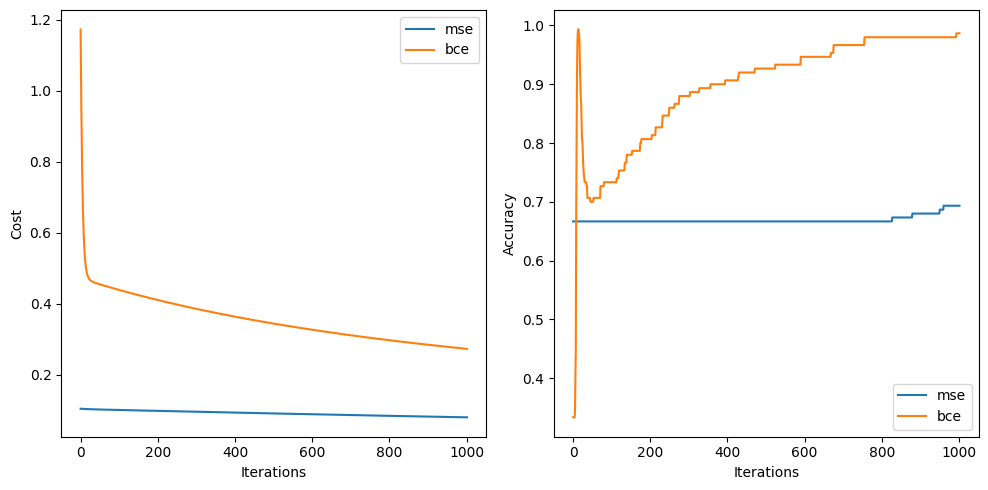

In [13]:
plot_with_accuracy(cost_hist_mse, cost_hist_bce, t_hist_mse, t_hist_bce, x, y, logistic_model)

#### Normiert

In [14]:
#normiert x
#z-score skalierung
mu = x.mean(axis=0)
sigma = x.std(axis=0)
x_normiert = (x - mu) / sigma

"""
#x = np.log(x) # logarithmische skalierung

#lineare skalierung
x_min  = x.min(axis=0)
x_max = x.max(axis=0)
x = (x - x_min) / (x_max - x_min)
"""
print("BCE- gradient descent:")
cost_hist_bce, t_hist_bce = gradient_descent(x_normiert, y,x_normiert.shape[1]+1,
                                     logistic_model,
                                     grad_logistic_model,
                                     bce_cost_function,
                                     grad_bce_cost_function, epsilon=0.01, alpha=0.01, verbose=True,max_iterations=1000)
print("\nMSE- gradient descent:")
cost_hist_mse, t_hist_mse = gradient_descent(x_normiert, y,x_normiert.shape[1]+1,
                                     logistic_model,
                                     grad_logistic_model,
                                     mse_cost_function,
                                     grad_mse_cost_function, epsilon=0.001, alpha=0.01, verbose=True,max_iterations=1000)

last_theta_bce = t_hist_bce[-1]
last_theta_mse = t_hist_mse[-1]

print("\nAccuracy BCE:", compute_accuracy(x_normiert, y, last_theta_bce, logistic_model))
print("Accuracy MSE:", compute_accuracy(x_normiert, y, last_theta_mse, logistic_model))


BCE- gradient descent:
final result
	cost: 0.2120805588542393, 
	theta: [-0.52051432 -1.31350844  1.12003405], 
	number of iterations: 1000, 
	gradient: 0.7496315708371427

MSE- gradient descent:
final result
	cost: 0.06811150711981535, 
	theta: [ 0.01118867 -0.87172665  0.17738191], 
	number of iterations: 1000, 
	gradient: 0.11321669264959296

Accuracy BCE: 0.98
Accuracy MSE: 0.8466666666666667


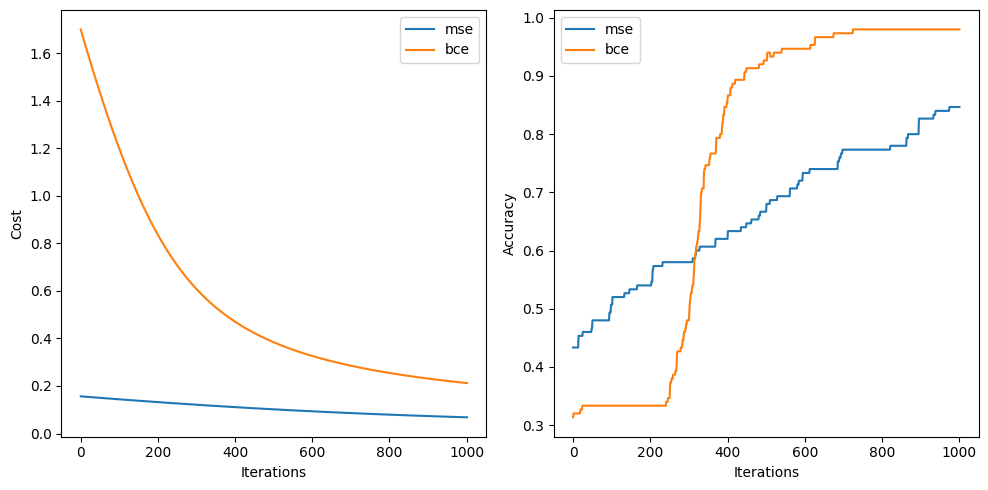

In [15]:
plot_with_accuracy(cost_hist_mse, cost_hist_bce, t_hist_mse, t_hist_bce, x_normiert, y, logistic_model)

## Kostenfunktionen- Visualisierung

### Plot

In [16]:
def plot_costs(x,y):
    theta0 = np.linspace(-40, 20, 100)
    theta1 = np.linspace(-40, 20, 100)
    Theta0, Theta1 = np.meshgrid(theta0, theta1)

    mse_costs = np.zeros_like(Theta0)
    bce_costs = np.zeros_like(Theta0)

    for i in range(Theta0.shape[0]):
        for j in range(Theta0.shape[1]):
            theta = np.array([Theta0[i, j], Theta1[i, j]])
            mse_costs[i, j] = mse_cost_function(x, y, logistic_model)(theta)
            bce_costs[i, j] = bce_cost_function(x, y, logistic_model)(theta)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].contour(Theta0, Theta1, bce_costs, levels=20)
    ax[0].set_title("BCE")
    ax[0].set_xlabel(r"$\theta_0$")
    ax[0].set_ylabel(r"$\theta_1$")

    ax[1].contour(Theta0, Theta1, mse_costs, levels=20)
    ax[1].set_title("MSE")
    ax[1].set_xlabel(r"$\theta_0$")
    ax[1].set_ylabel(r"$\theta_1$")
    plt.tight_layout()
    plt.show()

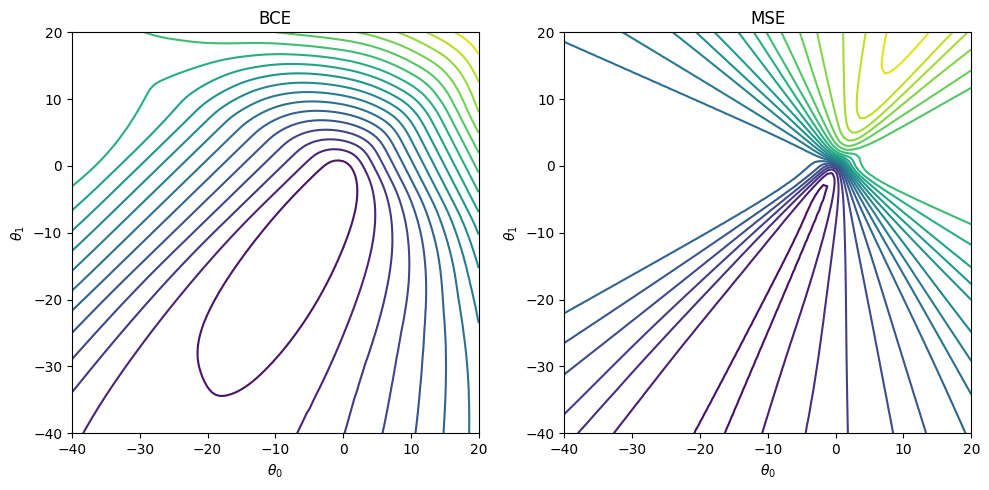

In [17]:
x_one = iris.data[:, 0:1]
y_one = (iris.target == 0).astype(int)

mu = x_one.mean(axis=0)
sigma = x_one.std(axis=0)
x_one = (x_one - mu) / sigma

plot_costs(x_one, y_one)

## Multivariate lineare Regression

### Funktionen

In [18]:
def linear_model(theta):
    def model(x):
        y = []
        for xi in x:
            yi = theta[0] + np.dot(theta[1:], xi)
            y.append(yi)
        return np.array(y)

    return model


def grad_linear_model(x, theta):
    G = np.zeros([len(x), len(theta)])
    for i in range(len(x)):
        xi = x[i]
        G[i][0] = 1
        G[i][1:] = xi
    return G

### Ergebnis

In [19]:
x_d = diabetes.data
y_d = diabetes.target

#unscaled
print("Unscaled- gradient descent:")
costs_diab_unscaled, thetas_diab_unscaled = gradient_descent(x_d, y_d,x_d.shape[1]+1,
                                     linear_model,
                                     grad_linear_model,
                                     mse_cost_function,
                                     grad_mse_cost_function, epsilon=0.001, alpha=0.01, verbose=True,max_iterations=1000)
last_cost_unscaled = costs_diab_unscaled[-1]

#scaled
scaler =StandardScaler()
x_scaled = scaler.fit_transform(x_d)

print("\nScaled- gradient descent:")
costs_diab_scaled, thetas_diab_scaled = gradient_descent(x_scaled, y_d,x_scaled.shape[1]+1,
                                     linear_model,
                                     grad_linear_model,
                                     mse_cost_function,
                                     grad_mse_cost_function, epsilon=0.001, alpha=0.01, verbose=True,max_iterations=1000)
last_cost_scaled = costs_diab_scaled[-1]

print(f"\nmse-unscaled: {last_cost_unscaled}")
print(f"mse-unscaled:  {last_cost_scaled}")

Unscaled- gradient descent:
final result
	cost: 2784.5920441449816, 
	theta: [152.12699239   4.65476488  -0.40314389  20.29704648  14.65576588
   7.58391528   4.96217019 -15.30276675  16.48385023  19.79238652
  13.49567479], 
	number of iterations: 1000, 
	gradient: 151.95603186251032

Scaled- gradient descent:
final result
	cost: 1439.338667527918, 
	theta: [152.12692116  -0.30974889 -11.26210297  25.17791523  15.34709048
  -4.62131407  -4.32039126  -9.08944152   5.72270388  22.96678752
   3.34375684], 
	number of iterations: 1000, 
	gradient: 179.65808801542968

mse-unscaled: 2784.5920441449816
mse-unscaled:  1439.338667527918
